In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil2 as teo

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# TEOTIL2 Metals

## Part 3: Metal concentrations though time

The analysis in the previous notebook shows that, using the 2019 "1000 Lakes" dataset, it is possible to build a TEOTIL2 Metals model for 2019 with reasonable performance. However, although the 2019 survey provides a lot of spatial detail, the last similar survey was 25 years ago. As has already been documented, changes in the limits of detection (LODs) between 1995 and 2019 make it difficult to assess temporal trends for metals using just these two datatsets. Nevertheless, it is important to be able to run TEOTIL2 Metals for different years - ideally across the whole period from 1990 to the present day.

The best monitoring data for exploring changes in metal concentrations over time comes from the "main rivers" in the Elveovervåkingprogrammet. However, these represent only part of Norway's total drainage area and many of the rivers have not been monitored for many years. Furthermore, these are all major rivers monitored close to their outflows, so they do not provide much information regarding spatial variability further inland. **For TEOTIL2 Metals, we need to be able to estimate changes in annual metal concentrations through time for each of Norway's ~20,000 regine catchments**.

This notebooks implements the following workflow:

 1. Extract all historic data for the 155 rivers in Elveovervåkingprogrammet that have been monitored since 1990
 
 2. Group these rivers according to their OSPAR region (with some slight modifications so that catchments draining to Sweden are also included - it is important that all regine catchments are classified). The aim of this regionalisation is to group rivers into related units so that a near-complete median time series can be estimated for each region (even if no single site in any region has a complete record). The water chemistry record for each region is then assumed to be representative of broad temporal trends in that area (for both monitored and unmonitored rivers)
 
 3. Calculate **change factors** for each region relative to 2019. These factors can then be applied to the statistical summaries calculated in the previous notebook based on spatially interpolation of the 2019 1000 Lakes dataset
 
 4. Estimate annual metal concentrations through time for each regine cacthment by applying regional change factors to the 2019 dataset. Detailed spatial patterns from 2019 will therefore be preserved, but modified through time according to regional temporal patterns. This approach is similar to the way the original TEOTIL model estimates annual discharges for each regine catchment by applying change factors calculated for the 247 "main rivers" to long-term average values

## 1. Define regions

The current Elveovervåkingprogramme/OSPAR reporting methodology groups Norway's main rivers basins into four OSPAR regions:

 * **Skagerrak**: vassdragsområder 1 to 23
 * **North Sea**: vassdragsområder 24 to 90
 * **Norwegian Sea (2)**: vassdragsområder 91 to 170
 * **Lofoten-Barents Sea**: vassdragsområder 171 to 247
 
In addition, there are 15 mainland catchments not included above that drain to Sweden. However, in terms of deposition, climate, geology etc. it is fairly straightfoward to group these with the regions defined above:

 * **Lofoten-Barents Sea**: vassdragsområder 301 to 302
 * **Norwegian Sea (2)**: vassdragsområder 303 to 308
 * **Skagerrak**: vassdragsområder 309 to 315
 
This information has the added to the regine metadata files in `../data/core_input_data` and is illustrated below.

In [3]:
# Read regine shp
shp_path = r"../data/gis/reg_minste_f_wgs84.shp"
reg_gdf = gpd.read_file(shp_path).to_crs(epsg=32633)
reg_gdf.rename({"VASSDRAGNR": "regine"}, axis="columns", inplace=True)

# Read regine metadata
csv_path = r"../data/core_input_data/regine_2018_onwards.csv"
reg_df = pd.read_csv(csv_path, sep=";")

reg_gdf = reg_gdf.merge(reg_df[["regine", "ospar_region"]], how="left", on="regine")

reg_df.head()

,regine,regine_ned,a_reg_km2,q_sp_m3/s/km2,runoff_mm/yr,q_reg_m3/s,vassom,komnr,fylke,ospar_region
0,001.,1_2,0.00,0.000,0.000,0.00000,0,0,0,0
1,001.10,001.,1.41,0.014,441.504,0.01974,1,101,1,Skagerrak
2,001.1A1,001.10,1.16,0.014,441.504,0.01624,1,101,1,Skagerrak
3,001.1A20,001.1A1,0.35,0.010,315.360,0.00350,1,101,1,Skagerrak
4,001.1A2A,001.1A20,17.40,0.012,378.432,0.20880,1,101,1,Skagerrak


<AxesSubplot:>

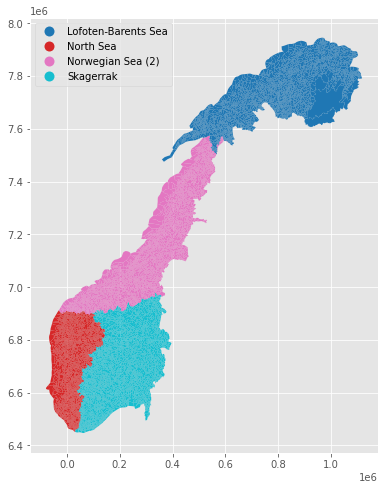

In [4]:
# Plot regions
reg_gdf.plot(
    column="ospar_region",
    edgecolor="none",
    figsize=(8, 8),
    legend=True,
    legend_kwds={"loc": "upper left"},
)

## 2. Extract monitoring data

The code below extracts all measured metal concentrations for the 155 stations monitored as part of Elveovervåkingprogrammet since 1990.

### 2.1. Station details

In [5]:
# Read station details
stn_xlsx = r"../data/metals/rid20_obs_loads/RID_Sites_List_2017-2020.xlsx"
stn_df = pd.read_excel(stn_xlsx, sheet_name="RID_All")

# Tidy names for OSPAR regions
stn_df["ospar_region"].replace(
    {
        "SKAGERAK": "Skagerrak",
        "NORTH SEA": "North Sea",
        "NORWEGIAN SEA2": "Norwegian Sea (2)",
        "LOFOTEN-BARENTS SEA": "Lofoten-Barents Sea",
    },
    inplace=True,
)

stn_df.head()

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone
0,29612,BUSEDRA,Drammenselva,rid_11,rid_20,Skagerrak,R,012.A3,59.753995,10.008990,6624446.0,556695.0,32
1,29779,FINEALT,Altaelva,rid_11,rid_20,Lofoten-Barents Sea,R,212.A0,69.900992,23.286977,7759686.0,586586.0,34
2,29820,FINETAN,Tanaelva,rid_36,rid_20,Lofoten-Barents Sea,R,234.B41,70.229993,28.173988,7791949.0,544316.0,35
3,29821,HOREVOS,Vosso (Bolstadelvi),rid_11,rid_20,North Sea,R,062.C1,60.647000,6.112000,6726970.0,342124.0,32
4,29782,NOREVEF,Vefsna,rid_11,rid_20,Norwegian Sea (2),R,151.A4,65.749000,13.239000,7293064.0,419297.0,33


In [6]:
nivapy.spatial.quickmap(
    stn_df, lat_col="lat", lon_col="lon", popup="station_name", kartverket=True
)

### 2.2. Query database

In [7]:
# Pars and period of interest
st_yr = 1990
end_yr = 2019
par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]

In [8]:
# Get parameter IDs
par_df = nivapy.da.select_resa_station_parameters(
    stn_df, f"{st_yr}-01-01", f"{end_yr}-12-31", eng
)
par_df = par_df.query("parameter_name in @par_list")
par_df

64 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
1,223,As,µg/l
11,15,Cd,µg/l
14,225,Cr,µg/l
15,16,Cu,µg/l
26,226,Hg,ng/l
36,227,Ni,µg/l
42,20,Pb,µg/l
61,26,Zn,µg/l


In [9]:
# Get water chemistry
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df, par_df, f"{st_yr}-01-01", f"{end_yr}-12-31", eng, drop_dups=True
)

wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,As_µg/l,Cd_µg/l,Cr_µg/l,Cu_µg/l,Hg_ng/l,Ni_µg/l,Pb_µg/l,Zn_µg/l
,,,,,,,,,,,,,,
0,29612,BUSEDRA,Drammenselva,1990-01-11,0.0,0.0,NaN,0.10,NaN,1.4,2.0,NaN,0.6,2.0
1,29612,BUSEDRA,Drammenselva,1990-02-12,0.0,0.0,NaN,0.10,NaN,1.1,2.0,NaN,0.7,5.2
2,29612,BUSEDRA,Drammenselva,1990-03-13,0.0,0.0,NaN,0.10,NaN,1.4,2.0,NaN,0.5,4.8
3,29612,BUSEDRA,Drammenselva,1990-04-18,0.0,0.0,NaN,0.10,NaN,1.4,6.0,NaN,0.5,6.4
4,29612,BUSEDRA,Drammenselva,1990-05-21,0.0,0.0,NaN,0.11,NaN,1.3,3.0,NaN,0.5,3.6


Observed concentrations of Hg in Glomma in 1998 seem exceptionally high: one sample from 15-04-1998 has a concentration of 915 ng/l and another on 16-11-1998 has a concentration of 730 ng/l (the next highest value in the dataset in around 50 ng/l, and most values are close to zero). This either implies some kind of industrial accident or - more likely - a problem with the data in the database. Regardless, including these values in the averages for the whole region will skew model predictions for the whole of Skagerrak, so I will remove these two values from the dataset.

In [10]:
# Set very high Hg values to NaN
wc_df["Hg_ng/l"] = np.where(wc_df["Hg_ng/l"] > 700, np.nan, wc_df["Hg_ng/l"])

## 3. Aggregate to regions

Calculate average annual time series for each station. The plots below group the stations by region: red lines show the mean time series per region; red shading shows the 95% range of values for stations in each region.

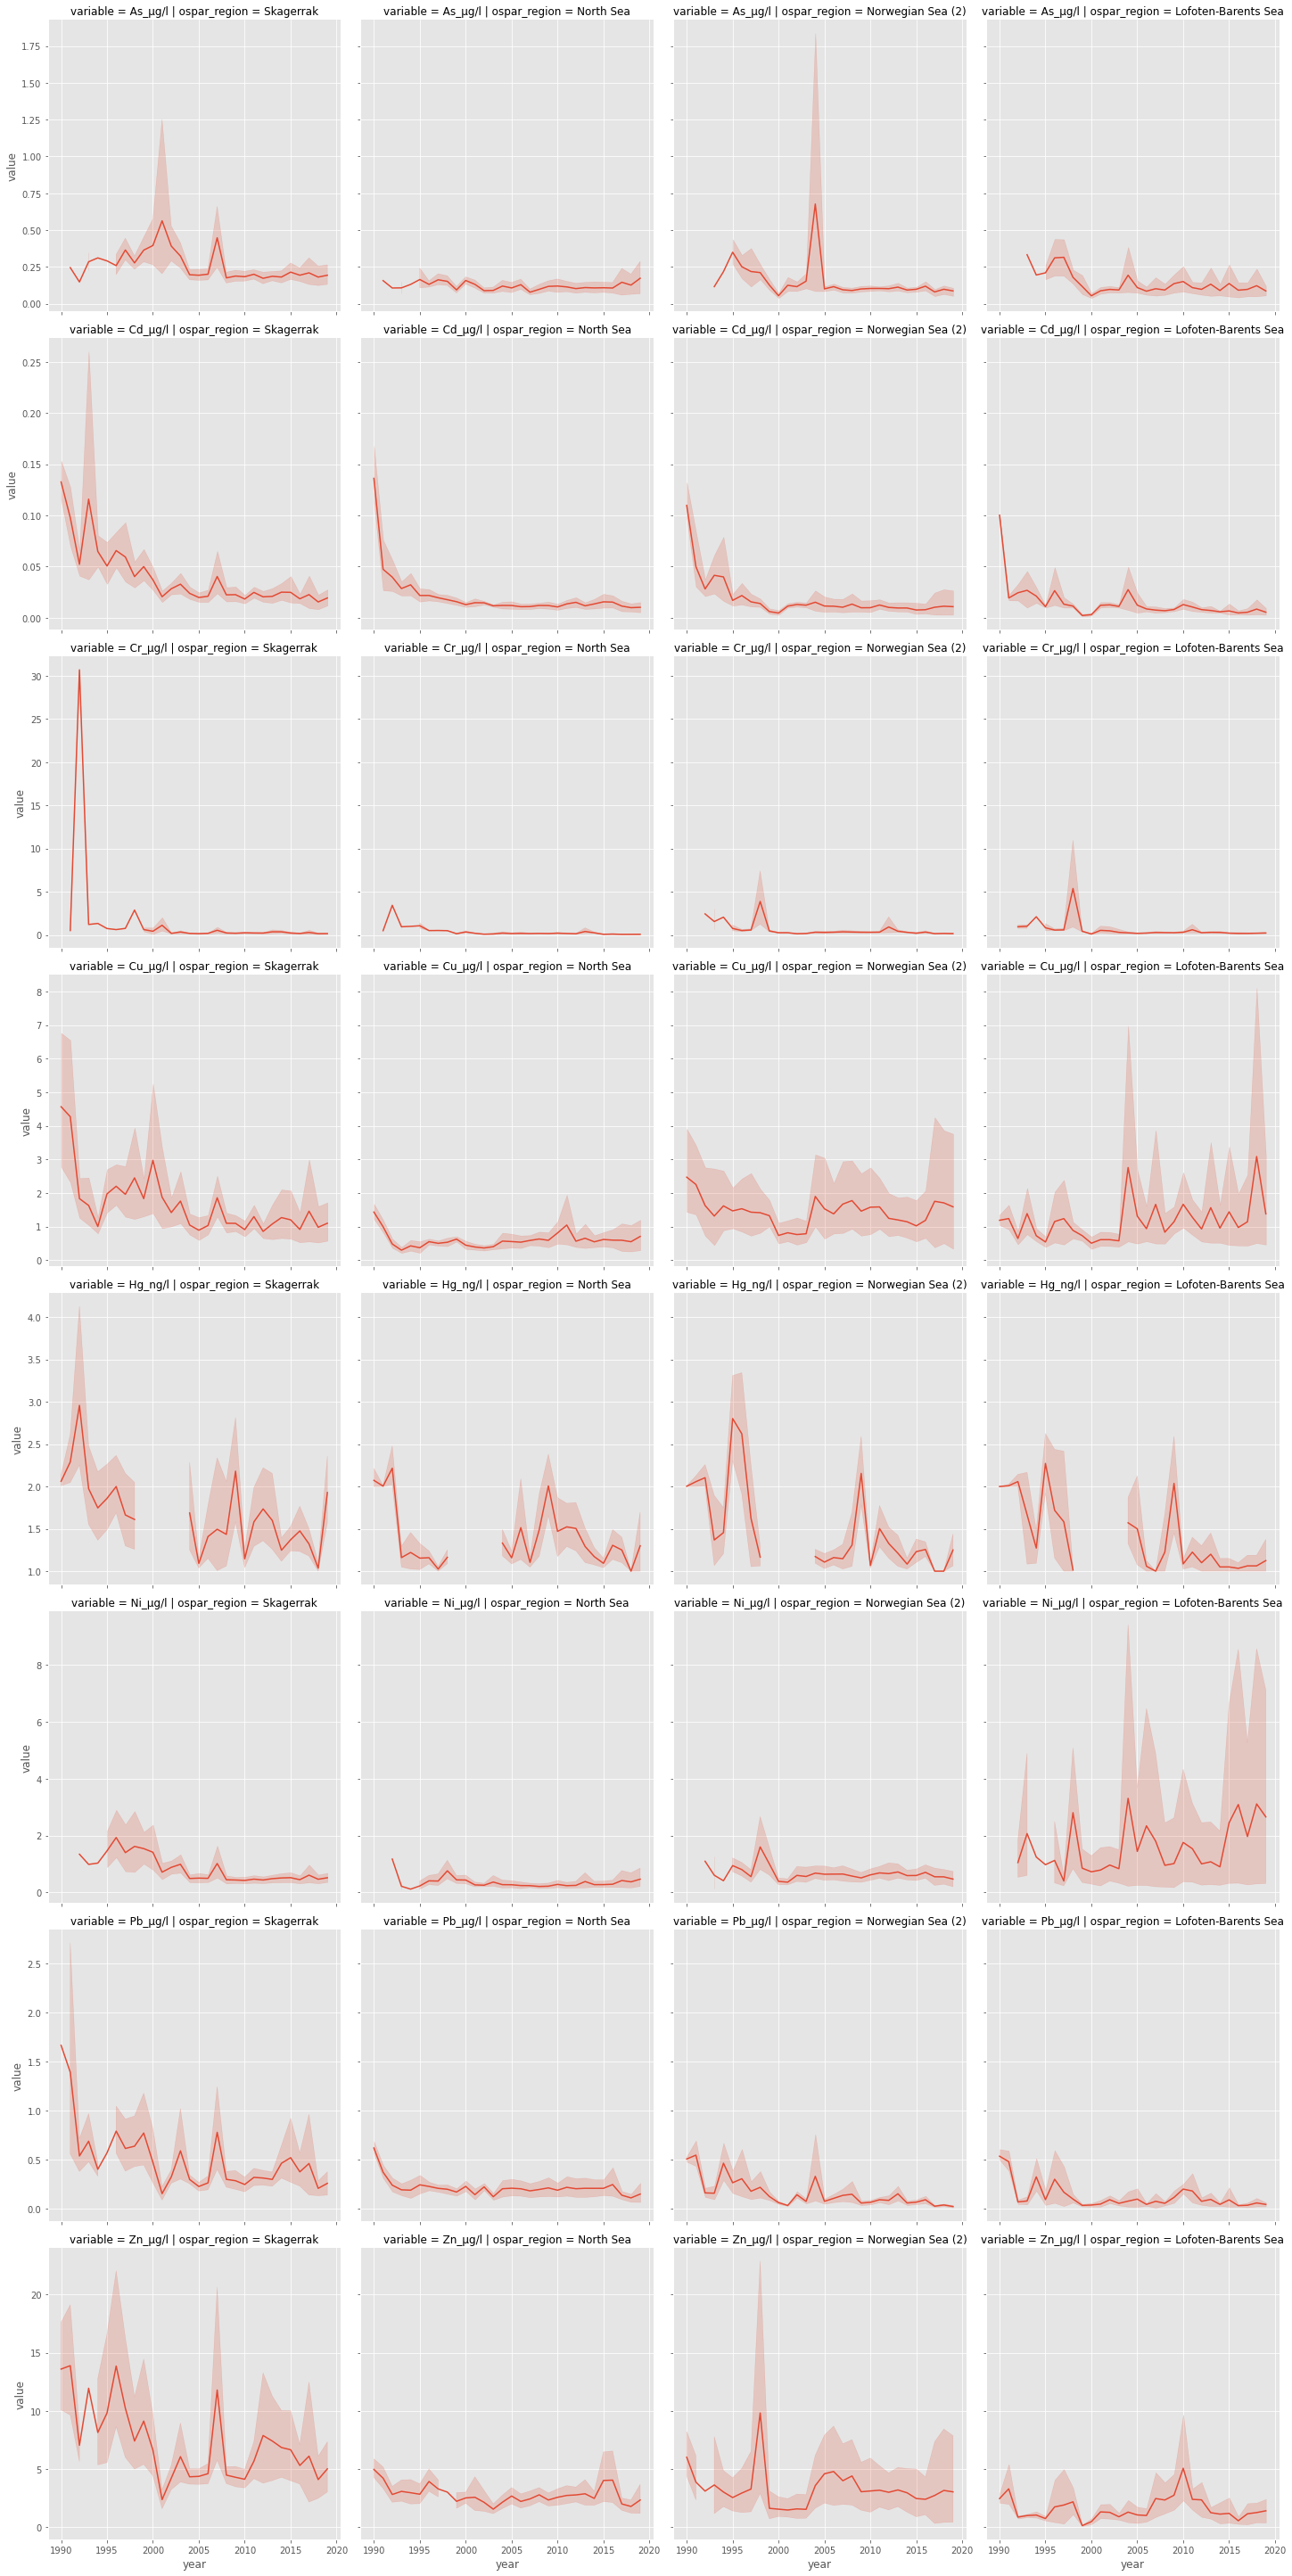

In [11]:
# Annual means for stations
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = (
    wc_df.groupby(["station_id", "station_code", "station_name", "year"])
    .mean()
    .reset_index()
)

# Join region names
ann_df = pd.merge(
    ann_df, stn_df[["station_id", "ospar_region"]], on="station_id", how="left"
)

# Plot mean of data per par and region, together with 95% CI
ann_df.drop(
    ["station_id", "station_code", "station_name", "depth1", "depth2"],
    axis="columns",
    inplace=True,
)
ann_df_long = ann_df.melt(id_vars=["ospar_region", "year"])

sn.relplot(
    data=ann_df_long,
    x="year",
    y="value",
    col="ospar_region",
    row="variable",
    kind="line",
    col_order=["Skagerrak", "North Sea", "Norwegian Sea (2)", "Lofoten-Barents Sea"],
    facet_kws={"sharex": True, "sharey": "row"},
)

png_path = r"../plots/metals/1k_lakes/ann_metal_concs_by_ospar_reg_raw.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")

The code below calculates mean time series for each region and then linearly interpolates over data gaps. Any remaining NaN values at the start of the series are then patched by "backfilling", and the series for each region and parameter are smoothed using a **median moving window of width 3**. The purpose of this is to remove large spikes in the data above, some of which look spurious. Finally, the values in each series are **divided by the value in 2019** to express each time series as a set of **change factors** that can be applied to the spatially interpolated 1000 Lakes dataset.

In [12]:
# Annual means for regions
ann_df = ann_df.groupby(["ospar_region", "year"]).mean().reset_index()
ann_df.head()

,ospar_region,year,As_µg/l,Cd_µg/l,Cr_µg/l,Cu_µg/l,Hg_ng/l,Ni_µg/l,Pb_µg/l,Zn_µg/l
0,Lofoten-Barents Sea,1990,NaN,0.100268,NaN,1.188393,2.000000,NaN,0.535714,2.449107
1,Lofoten-Barents Sea,1991,NaN,0.019375,NaN,1.239286,2.008929,NaN,0.480357,3.291071
2,Lofoten-Barents Sea,1992,NaN,0.024464,0.952143,0.646786,2.058036,1.052143,0.069643,0.856786
3,Lofoten-Barents Sea,1993,0.332500,0.026875,1.007500,1.386875,1.666667,2.072500,0.079375,0.989375
4,Lofoten-Barents Sea,1994,0.194815,0.021250,2.111852,0.728393,1.272321,1.247037,0.325089,1.033393


In [13]:
# Fill NaNs with linear interpolation and back-filling where necessary
df_list = []
for reg in ann_df["ospar_region"].unique():
    reg_df = ann_df.query("ospar_region == @reg").copy()
    #    reg_df.drop({"station_id", "depth1", "depth2"}, inplace=True, axis="columns")

    assert len(reg_df) == 30

    # Fill NaN
    reg_df.sort_values("year", inplace=True)
    reg_df.interpolate(method="linear", inplace=True)
    reg_df.fillna(method="backfill", inplace=True)

    assert pd.isna(reg_df).all().all() == False

    reg_df.set_index(["ospar_region", "year"], inplace=True)

    # Calculate ratios to 2019
    for col in reg_df.columns:
        # Apply rolling median smooth with window width of 3 years to remove huge spikes
        reg_df[col] = (
            reg_df[col]
            .rolling(window=3, center=True, win_type=None, min_periods=1)
            .median()
        )
        df_2019 = reg_df.query("year == 2019")
        reg_df[col] = reg_df[col] / df_2019[col].iloc[0]

        reg_df.rename(
            {col: f"{col.split('_')[0].lower()}_div_2019"}, inplace=True, axis="columns"
        )

    reg_df.reset_index(inplace=True)

    df_list.append(reg_df)

ann_df = pd.concat(df_list, axis=0)
ann_df = ann_df.round(2)

ann_csv = r"../data/core_input_data/ospar_region_mean_metals_div_2019_smooth.csv"
ann_df.to_csv(ann_csv, index=False)

ann_df.head()

,ospar_region,year,as_div_2019,cd_div_2019,cr_div_2019,cu_div_2019,hg_div_2019,ni_div_2019,pb_div_2019,zn_div_2019
0,Lofoten-Barents Sea,1990,3.18,8.53,4.44,0.54,1.83,0.36,9.82,2.17
1,Lofoten-Barents Sea,1991,3.18,3.49,4.44,0.53,1.84,0.36,9.29,1.85
2,Lofoten-Barents Sea,1992,3.18,3.49,4.44,0.55,1.84,0.36,1.53,0.75
3,Lofoten-Barents Sea,1993,3.18,3.49,4.70,0.33,1.52,0.43,1.53,0.75
4,Lofoten-Barents Sea,1994,2.01,3.03,4.70,0.33,1.52,0.43,1.80,0.75


The plots below show the change factors for metals used by TEOTIL2 in region to estimate changing concentrations through time.

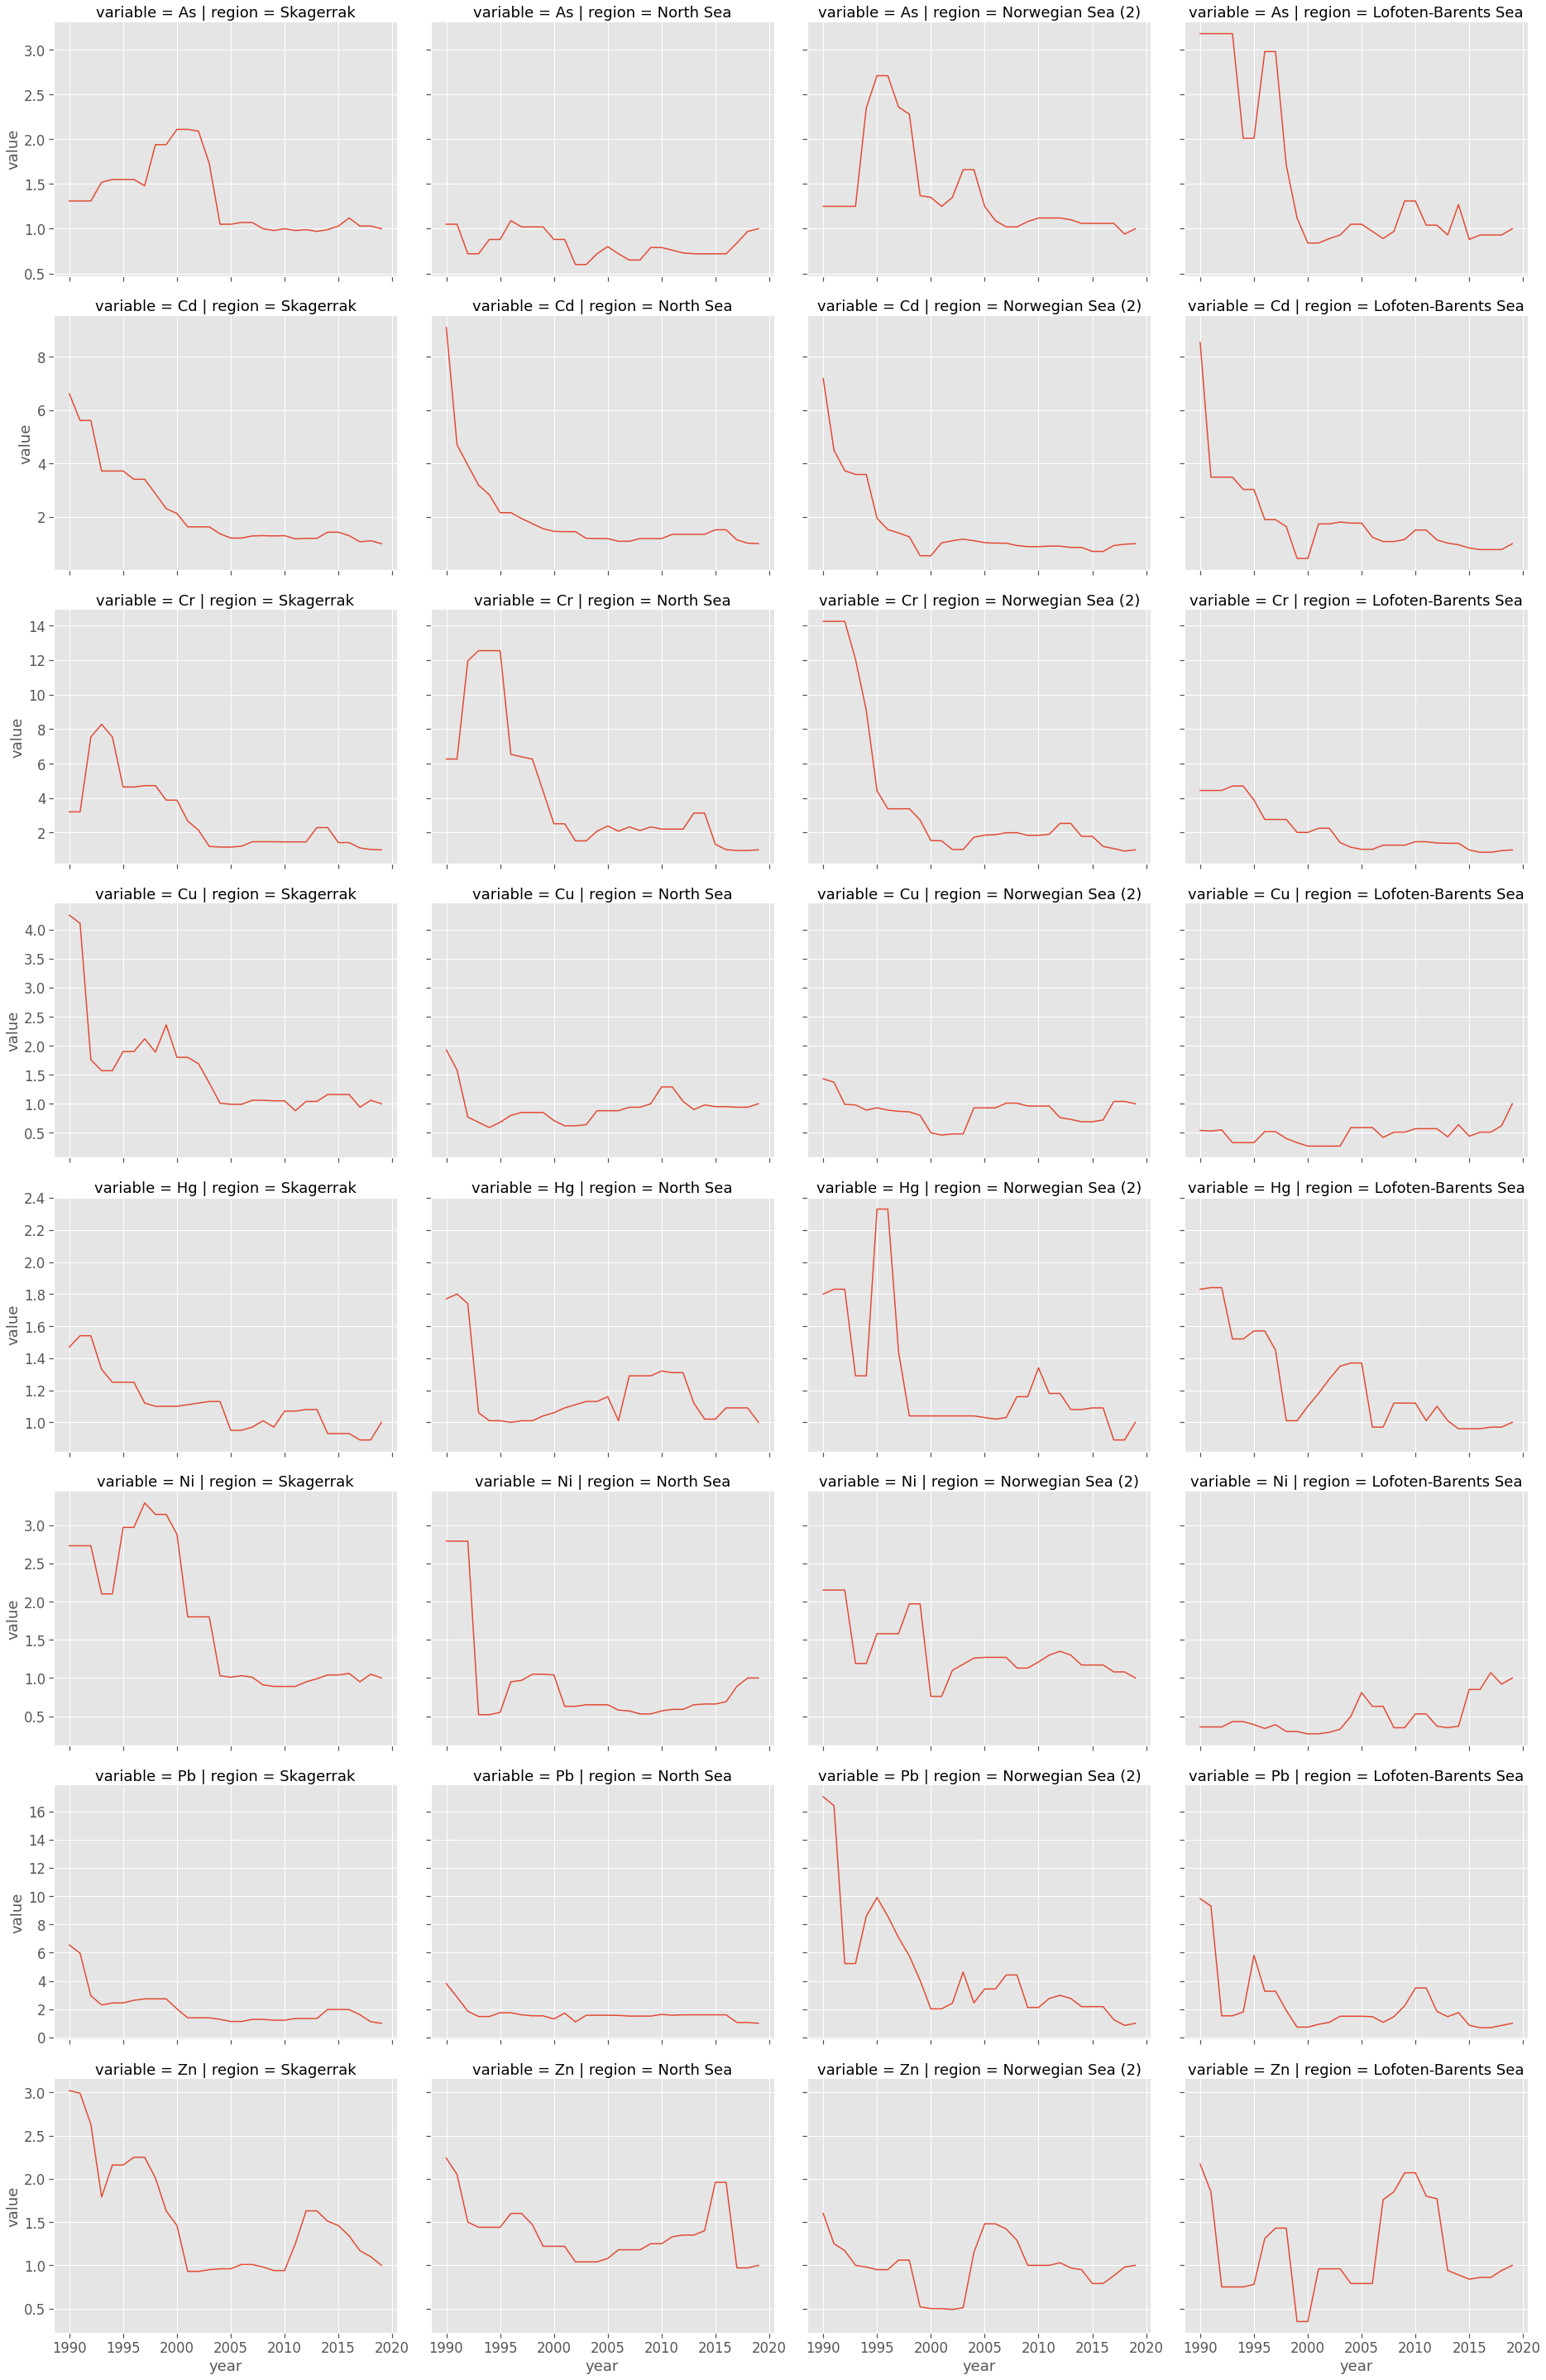

In [14]:
# Plot smoothed regional patterns
ann_df = ann_df.melt(id_vars=["ospar_region", "year"])
ann_df['variable'] = ann_df['variable'].str[:2].str.capitalize()
ann_df.rename({'ospar_region':'region'}, axis='columns', inplace=True)

with sn.plotting_context("notebook", font_scale=1.5):
    sn.relplot(
        data=ann_df,
        x="year",
        y="value",
        col="region",
        row="variable",
        col_order=["Skagerrak", "North Sea", "Norwegian Sea (2)", "Lofoten-Barents Sea"],
        facet_kws={"sharey": "row", "sharex": True},
        kind="line",
        aspect=1.3,
    )

png_path = r"../plots/metals/1k_lakes/ann_metal_concs_by_ospar_reg_interp_smooth.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 4. TEOTIL2 function

For convenience, I have packaged the code in this notebook into a TEOTIL2 function that can be used to quickly regenerate or update the change factor file. Usage is illustrated below,

In [15]:
fac_df = teo.io.estimate_metal_change_factors_over_time(
    1990,
    2019,
    eng,
    par_list=["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"],
    agg_stat="mean",
    smooth=True,
    omit_stns=None,
    out_csv=None,
)

fac_df.tail()

64 parameters available for the selected stations and dates.


/opt/conda/lib/python3.8/site-packages/nivapy3-0.1-py3.8.egg/nivapy3/da.py:728: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,ospar_region,year,as_div_2019,cd_div_2019,cr_div_2019,cu_div_2019,hg_div_2019,ni_div_2019,pb_div_2019,zn_div_2019
25,Skagerrak,2015,1.03,1.43,1.42,1.16,0.93,1.04,1.98,1.46
26,Skagerrak,2016,1.12,1.30,1.42,1.16,0.93,1.06,1.97,1.34
27,Skagerrak,2017,1.03,1.07,1.11,0.94,0.89,0.95,1.61,1.17
28,Skagerrak,2018,1.03,1.11,1.02,1.06,0.89,1.05,1.11,1.10
29,Skagerrak,2019,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
